In [2]:
import sys
import numpy as np
sys.path.append("../src/")
from smearing_matrix import *

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-pr2gjz9v because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Welcome to JupyROOT 6.22/06


In [3]:
#######################################################################
# Declare ROOT files for the Analysis
#######################################################################
mc_files=get_first_N_files("../projects/test/volatile/data/piplus_piminus/",1,"MC_RGA_*")
data_files=get_first_N_files("../projects/test_data/volatile/data/piplus_piminus/",5,"nSidis_RGA_*")

In [4]:
#######################################################################
# 1d Rectangular Binning
#######################################################################

rect_bin_factory = RectBinFactory()
rect_bin_factory.make_bins("rec_z",np.linspace(0.3,1,50))

In [5]:
#######################################################################
# Load 1d Rectangular Binning into the BinManager
#######################################################################

bin_manager = BinManager()
bin_manager.load_factory(rect_bin_factory)

In [8]:
#######################################################################
# Create and run smearing matrix
#######################################################################

smearing_matrix = SmearingMatrix(mc_files, bin_manager)

smearing_matrix.run()

100%|████████████████████████████████████████████| 1/1 [00:14<00:00, 14.80s/it]


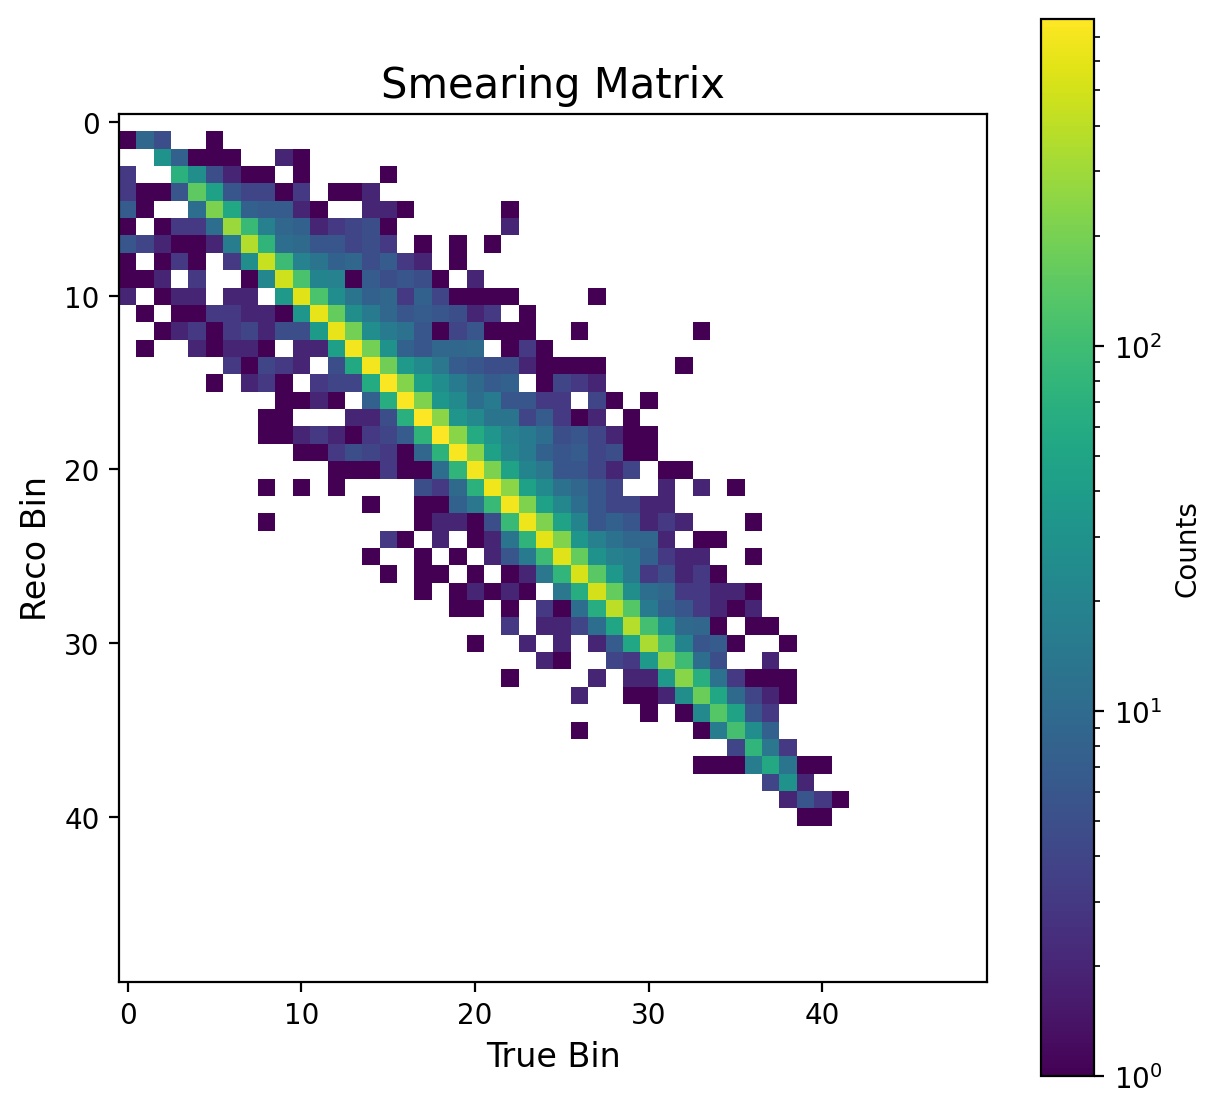

In [9]:
smearing_matrix.draw_smearing_matrix(do_log_scale=True,
                                     show_overflow=True)

In [10]:
#######################################################################
# Perform unfolding
#######################################################################
%run ../src/unfold.py


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



In [11]:
usable_bins = smearing_matrix.bin_manager.total_bins - 1 # We do not unfold overflow/underflow bins
true_bins = smearing_matrix.true_bins
reco_bins = smearing_matrix.reco_bins
dataloader = DataLoader(bin_manager)
data = dataloader.read_binned_data_from_data_file(data_files)
data_bins = bin_manager.get_bin_ids(*data)


100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 34.55it/s]


In [12]:
reco_hist,true_hist,data_hist,unfolded_hist = Unfold.perform_RooUnfold(usable_bins,true_bins,reco_bins,data_bins,"bayes")

An additional truth bin is added to handle 1020 fakes.
Now unfolding...
Iteration : 0
Chi^2 of change 1.47681e+07
Iteration : 1
Chi^2 of change 483584
Iteration : 2
Chi^2 of change 112405
Iteration : 3
Chi^2 of change 46106.3
Iteration : 4
Chi^2 of change 20834.5
Iteration : 5
Chi^2 of change 9842.26
Iteration : 6
Chi^2 of change 4904.18
Iteration : 7
Chi^2 of change 2603.18
Iteration : 8
Chi^2 of change 1476.36
Iteration : 9
Chi^2 of change 892.192
Iteration : 10
Chi^2 of change 571.277
Iteration : 11
Chi^2 of change 385.076
Iteration : 12
Chi^2 of change 271.582
Iteration : 13
Chi^2 of change 199.329
Iteration : 14
Chi^2 of change 151.536
Iteration : 15
Chi^2 of change 118.825
Iteration : 16
Chi^2 of change 95.7303
Iteration : 17
Chi^2 of change 78.948
Iteration : 18
Chi^2 of change 66.4161
Iteration : 19
Chi^2 of change 56.8129
Iteration : 20
Chi^2 of change 49.2715
Iteration : 21
Chi^2 of change 43.2041
Iteration : 22
Chi^2 of change 38.2287
Iteration : 23
Chi^2 of change 34.0722
I

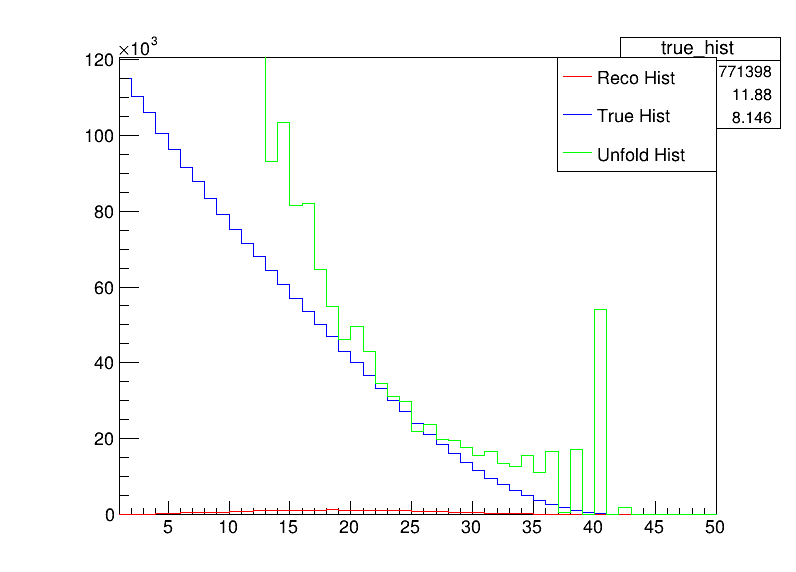

In [13]:
canvas = ROOT.TCanvas("canvas", "Histograms", 800, 600)
ROOT.gPad.SetLeftMargin(0.15)
reco_clone = reco_hist.Clone()
reco_clone.SetLineColor(ROOT.kRed)
reco_clone.SetTitle(";Bin Entry;Counts")
true_clone = true_hist.Clone()
true_clone.SetLineColor(ROOT.kBlue)

unfold_clone = unfolded_hist.Clone()
unfold_clone.SetLineColor(ROOT.kGreen)

true_clone.Draw("hist")
reco_clone.Draw("hist same")
unfold_clone.Draw("hist same")

legend = ROOT.TLegend(0.7, 0.7, 0.9, 0.9)
legend.AddEntry(reco_clone, "Reco Hist", "l")
legend.AddEntry(true_clone, "True Hist", "l")
legend.AddEntry(unfold_clone, "Unfold Hist", "l")
legend.Draw()

canvas.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


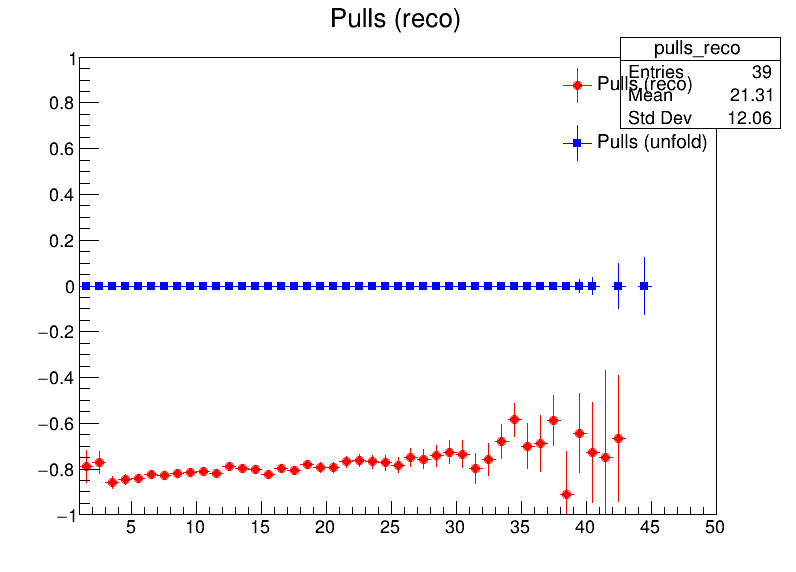

In [29]:

# Create a canvas to display the plots
canvas = ROOT.TCanvas("canvas", "Pulls", 800, 600)

# Calculate the pulls by subtracting true_hist from reco_hist and hUnfold
pulls_reco = reco_hist.Clone()
pulls_reco.Add(true_hist, -1)
pulls_reco.SetName("pulls_reco")
pulls_reco.SetTitle("Pulls (reco)")
pulls_reco.SetLineColor(ROOT.kRed)
pulls_reco.SetMarkerColor(ROOT.kRed)
pulls_reco.SetMarkerStyle(ROOT.kFullCircle)

pulls_unfold = hUnfold.Clone()
pulls_unfold.Add(true_hist, -1)
pulls_unfold.SetName("pulls_unfold")
pulls_unfold.SetTitle("Pulls (unfold)")
pulls_unfold.SetLineColor(ROOT.kBlue)
pulls_unfold.SetMarkerColor(ROOT.kBlue)
pulls_unfold.SetMarkerStyle(ROOT.kFullSquare)

# Set the bin content errors as the square root of bin counts for all histograms
for bin in range(1, true_hist.GetNbinsX() + 1):
    reco_content = reco_hist.GetBinContent(bin)
    reco_error = reco_content ** 0.5
    reco_hist.SetBinError(bin, reco_error)

    true_content = true_hist.GetBinContent(bin)
    true_error = true_content ** 0.5
    true_hist.SetBinError(bin, true_error)

    unfold_content = hUnfold.GetBinContent(bin)
    unfold_error = unfold_content ** 0.5
    hUnfold.SetBinError(bin, unfold_error)

    # Calculate the pulls with error propagation (avoiding division by zero)
    if true_content != 0:
        pull_reco = pulls_reco.GetBinContent(bin)
        pull_reco_error = ((reco_error / true_content) ** 2 + (reco_content * true_error / true_content ** 2) ** 2) ** 0.5
        pulls_reco.SetBinError(bin, pull_reco_error)

        pull_unfold = pulls_unfold.GetBinContent(bin)
        pull_unfold_error = ((unfold_error / true_content) ** 2 + (unfold_content * true_error / true_content ** 2) ** 2) ** 0.5
        pulls_unfold.SetBinError(bin, pull_unfold_error)
    else:
        pulls_reco.SetBinContent(bin, 0)
        pulls_reco.SetBinError(bin, 0)
        pulls_unfold.SetBinContent(bin, 0)
        pulls_unfold.SetBinError(bin, 0)

# Divide the pulls histograms by true_hist for error propagation
pulls_reco.Divide(true_hist)
pulls_unfold.Divide(true_hist)

# Draw the pull histograms on the canvas, excluding data points with error bars larger than epsilon
epsilon = 0.4
for bin in range(1, true_hist.GetNbinsX() + 1):
    pull_reco_error = pulls_reco.GetBinError(bin)
    if pull_reco_error >= epsilon:
        pulls_reco.SetBinContent(bin, 0)
        pulls_reco.SetBinError(bin, 0)

    pull_unfold_error = pulls_unfold.GetBinError(bin)
    if pull_unfold_error >= epsilon:
        pulls_unfold.SetBinContent(bin, 0)
        pulls_unfold.SetBinError(bin, 0)

pulls_reco.Draw("PE")
pulls_unfold.Draw("PE SAME")

pulls_reco.GetYaxis().SetRangeUser(-1,1)
# Create a legend
legend = ROOT.TLegend(0.7, 0.7, 0.9, 0.9)
legend.AddEntry(pulls_reco, "Pulls (reco)", "lep")
legend.AddEntry(pulls_unfold, "Pulls (unfold)", "lep")
legend.SetBorderSize(0)
legend.SetFillStyle(0)
legend.Draw()

# Update the canvas and display the plot
canvas.Update()
canvas.Draw()